In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim

numpy = lambda x : x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

In [2]:
# Preprocessing
# np_img1 = plt.imread('../data/curie.pgm').astype('float')
np_img1 = plt.imread('../data/einstein.png').astype('float')[:,:,0]
# np_img1 = plt.imread('../data/cat7-elephant1.png').astype('float')

# normalize values between 0-1
np_img1 = po.rescale(np_img1)

# if len(np_img1.shape) == 2:                  # if no channel dimension exists
#     np_img1 = np.expand_dims(np_img1, axis=-1)
# np_img1 = np.transpose(np_img1, (2, 0, 1))   # adjust dimensions for pytorch
# np_img1 = np.expand_dims(np_img1, axis=0)    # add batch dimension
# np_img1 = np_img1 / 255.0                    # normalize values between 0-1
# np_img1 = np_img1.astype(np.float32)         # adjust type

# img1 = torch.from_numpy(np_img1)
img1 = torch.tensor(np_img1, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
img2 = torch.rand_like(img1, requires_grad=True).to(device)

img1.requires_grad = False
img2.requires_grad = True

In [3]:
# loss_func = lambda x, y: 1 - po.synth.ssim(x, y)
# loss_func = lambda x, y: 1 - po.synth.msssim(x, y)
# loss_func = po.metric.nlpd
loss_func = po.metric.nspd

value = loss_func(img1, img2)
print("Initial distance: %.5f" % (value.item()))
assert value.requires_grad

Initial distance: 3.45384


In [4]:
optimizer = optim.Adam([img2], lr=0.01, amsgrad=True)

# MSSSIM yields higher values for worse results,
# because noise is removed in scales with lower resolutions

# threshold = 0.5
threshold = 0.001
max_iter = 500

I = []
l = []
i = 0
while value > threshold and i < max_iter:

    i += 1
    optimizer.zero_grad()
    loss = loss_func(img1, img2)
    value = loss.item()
    print(f'iter {i} distance = %{value:.5f}')
    loss.backward()
    optimizer.step()
    
    l.append(value)
    I.append(numpy(img2).copy())

iter 1 distance = %3.45384
iter 2 distance = %3.31832
iter 3 distance = %3.17928
iter 4 distance = %3.04651
iter 5 distance = %2.92126
iter 6 distance = %2.80896
iter 7 distance = %2.71504
iter 8 distance = %2.63209
iter 9 distance = %2.56506
iter 10 distance = %2.50954
iter 11 distance = %2.46200
iter 12 distance = %2.42353
iter 13 distance = %2.38777
iter 14 distance = %2.35850
iter 15 distance = %2.32950
iter 16 distance = %2.30129
iter 17 distance = %2.27511
iter 18 distance = %2.24990
iter 19 distance = %2.22618
iter 20 distance = %2.20868
iter 21 distance = %2.18675
iter 22 distance = %2.16374
iter 23 distance = %2.14231
iter 24 distance = %2.12056
iter 25 distance = %2.10192
iter 26 distance = %2.08317
iter 27 distance = %2.06525
iter 28 distance = %2.04765
iter 29 distance = %2.02984
iter 30 distance = %2.01596
iter 31 distance = %2.00017
iter 32 distance = %1.98452
iter 33 distance = %1.96970
iter 34 distance = %1.95610
iter 35 distance = %1.94065
iter 36 distance = %1.92705
i

Difference statistics:
  Range: [-1, 1]
  Mean: -0.097247,  Stdev (rmse): 0.338532,  SNR (dB): -6.328748


(-1.3794031, 1.3585865, -0.09724659, 0.3385322158448669, -6.328748331143602)

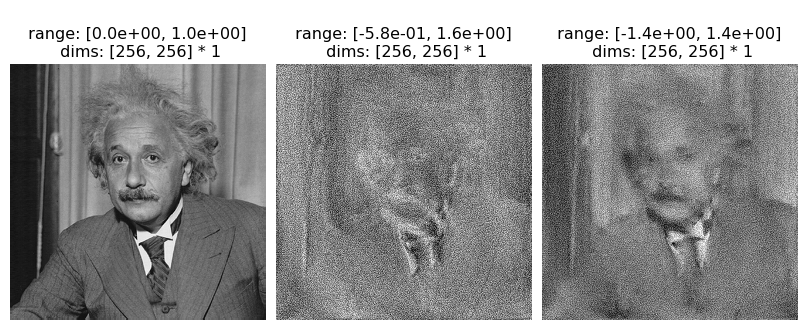

In [5]:
pt.imshow([numpy(img1), numpy(img2), numpy(img1) - numpy(img2)]);
pt.image_compare(numpy(img1), numpy(img2))

In [6]:
print('\n 1 - ssim: %.5f \n 1 - ms-ssim: %.5f \n nlpd: %.5f \n nspd: %.5f \n' % (
    1 - po.metric.ssim(img1, img2), 1 - po.metric.msssim(img1, img2), po.metric.nlpd(img1, img2), po.metric.nspd(img1, img2)))


 1 - ssim: 0.95332 
 1 - ms-ssim: nan 
 nlpd: 3.84885 
 nspd: 1.55119 



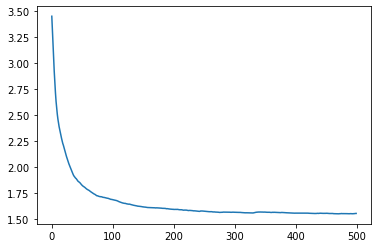

In [7]:
plt.plot(l)

In [8]:
pt.animshow(np.array(I), 25)

In [9]:
# def post_process(img):
#     img = img.detach().cpu().numpy()
#     img = np.transpose(np.squeeze(img, axis=0), (1, 2, 0))
#     img = np.squeeze(img)     # works if grayscale
#     return img

# # Post processing
# img1np = post_process(img1)
# img2 = torch.sigmoid(img2)
# img2np = post_process(img2)

# import matplotlib.pyplot as plt
# cmap = 'gray' if len(img1np.shape) == 2 else None
# plt.subplot(1, 2, 1)
# plt.imshow(img1np, cmap=cmap)
# plt.title('Original')
# plt.subplot(1, 2, 2)
# plt.imshow(img2np, cmap=cmap)
# plt.title('Generated, metric: {:.3f}'.format(value))
# plt.show()

In [10]:
im = []
for i in range(1,25):
    if i < 10:
        i = str(0) + str(i)
    im.append(plt.imread('/Users/pe/Documents/images/tid2013/reference_images/I'+str(i)+'.BMP'))

In [11]:
X = torch.tensor(po.rescale(np.transpose(np.stack(im), (0,3,1,2))), dtype=torch.float32)

X.shape

torch.Size([24, 3, 384, 512])

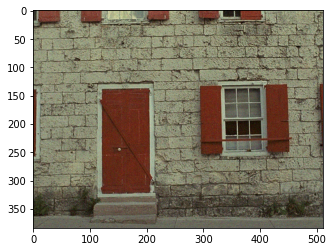

In [12]:
plt.imshow(plt.imread('/Users/pe/Documents/images/tid2013/distorted_images/i01_01_2.bmp'))

In [13]:
dtype = torch.float32

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [14]:
num_images = 25
num_distortions = 24
num_levels = 5

nlpd = []

for i in range(1, num_images + 1):
    if i < 10:
        i = str(0) + str(i)
    
    a = plt.imread('/Users/pe/Documents/images/tid2013/reference_images/I' + str(i) + '.BMP')

    for d in range(1, num_distortions + 1):
        if d < 10:
            d = str(0) + str(d)

        for l in range(1, num_levels + 1):
            if d == '01' and l == 1:
                im = 'I' + str(i)
            else:
                im = 'i' + str(i)
            b = plt.imread('/Users/pe/Documents/images/tid2013/distorted_images/' + im + '_' + str(d) + '_' + str(l) + '.bmp')
            
            A = torch.tensor(rgb2gray(a), dtype=dtype, device=device).unsqueeze(0).unsqueeze(0)
            B = torch.tensor(rgb2gray(b), dtype=dtype, device=device).unsqueeze(0).unsqueeze(0)
            
            nlpd.append(po.metric.perceptual_distance.nlpd(A, B))

In [15]:
nlpd = np.array(nlpd)

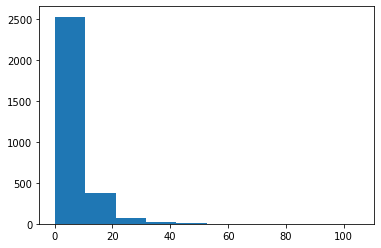

In [16]:
plt.hist(nlpd);

In [17]:
mos = np.loadtxt('/Users/pe/Documents/images/tid2013/mos.txt')

mos.shape

(3000,)

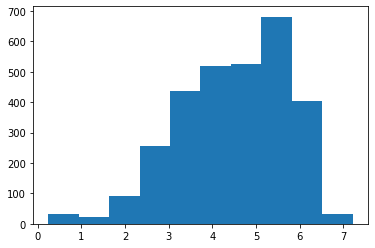

In [18]:
plt.hist(mos);

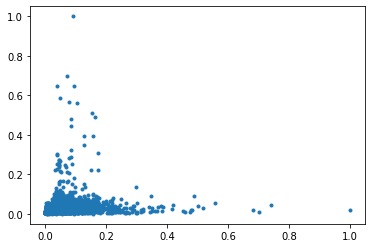

In [19]:
plt.plot(po.rescale(nlpd), po.rescale(1 / (mos)), '.')

In [20]:
(nlpd / np.linalg.norm(nlpd)) @ ((1 / mos) / np.linalg.norm(1 / mos))

0.5937195270021152